# Using ArcGIS Notebooks and ArcPy Charts to Explore Data

<a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/what-is-a-chart-.htm" target="_blank">ArcGIS Pro Charts</a> provide a powerful way to visualize and explore your data, helping to uncover patterns, trends, relationships, and structure that might not be apparent when looking at a table or map. The Charts development team has been working to add chart capabilities to <a href="https://pro.arcgis.com/en/pro-app/latest/arcpy/get-started/what-is-arcpy-.htm" target="_blank">ArcPy</a>, to support automation and spatial data science workflows using Python. It’s possible to do all your data preparation, visualization, and analysis completely inside ArcGIS—but you can also mix-and-match the ArcGIS Python libraries with your other favorite libraries.

This notebook demonstrates ArcPy Charts functionality by visualizing characteristics and trends of the COVID-19 pandemic in the United States during 2020.

## Preparing the Data 

To get started, I'll load and prepare the data using [pandas](https://pandas.pydata.org/), but you can use whatever Python tools you prefer.  I'm acquiring the data from the New York Times COVID-19 data repository (publicly accessible <a href="https://github.com/nytimes/covid-19-data" target="_blank">here</a>), and I'm filtering the data to include only dates from the complete year of 2020.  

In [1]:
import pandas as pd
from arcgis.features import GeoAccessor
import arcpy

arcpy.env.workspace = 'memory'
DATA_URL = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'

# load data with pandas, create new fields, and filter 
daily_df = (
    pd.read_csv(DATA_URL, parse_dates=['date'])
        .sort_values(['state', 'date'])
        .rename(columns={
            'cases': 'cases_total',
            'deaths': 'deaths_total'
        })
        .assign(
            cases_new = lambda df: df.groupby('state')['cases_total'].diff().clip(lower=0),
            deaths_new = lambda df: df.groupby('state')['deaths_total'].diff().clip(lower=0)
        )
        .query("'2020-01-01' <= date <= '2020-12-31'")
        .reset_index(drop=True)
)

Here's a quick look at the prepared dataset. Notice that there is an individual row for each `date` and `state` combination.  These rows will be summarized and aggregated when I visualize this data with charts. 

In [2]:
daily_df.head()

date    state  fips  cases_total  deaths_total  cases_new  deaths_new
0 2020-03-13  Alabama     1            6             0        NaN         NaN
1 2020-03-14  Alabama     1           12             0        6.0         0.0
2 2020-03-15  Alabama     1           23             0       11.0         0.0
3 2020-03-16  Alabama     1           29             0        6.0         0.0
4 2020-03-17  Alabama     1           39             0       10.0         0.0

Currently, pandas data structures cannot be directly used to create an ArcPy chart&mdash;though we hope to add this ability in the future.  Instead you must convert your data to a supported format such as a <a href="https://pro.arcgis.com/en/pro-app/arcpy/mapping/layer-class.htm" target="_blank">Layer</a> or <a href="https://pro.arcgis.com/en/pro-app/arcpy/mapping/table-class.htm" target="_blank">Table</a> object, a dataset path, or a feature service URL.  For this demo, I'll save the pandas DataFrame as an <a href="https://pro.arcgis.com/en/pro-app/help/analysis/geoprocessing/basics/the-in-memory-workspace.htm" target="_blank">in-memory</a> table using the <a href="https://developers.arcgis.com/python/" target="_blank">ArcGIS API for Python</a>. 

In [3]:
daily_df.spatial.to_table('covid_daily')

'memory\\covid_daily'

## Visualizing the Data 

Now that I've prepared the data with the proper fields and saved it in a supported format, I can explore it using ArcPy charts! 

First, I'll start simple and create a <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/bar-chart.htm" target="_blank">bar chart</a> showing the total COVID cases for each state. I do this by initializing an ArcPy <a href="https://pro.arcgis.com/en/pro-app/arcpy/classes/chart.htm" target="_blank">Chart</a> object and configuring the properties.  As illustrated in the table above, the dataset contains one row for each `state` and `date` combination, so here I use a `sum` aggregation to calculate the total `cases_new` values for each state.  Also take note of the `dataSource` property, which is used to specify the dataset you want to visualize.  Here I'm configuring the chart to use the in-memory table I created above.

Please note that charts displayed in notebooks are currently static, and therefore they will not be interactive as they are inside ArcGIS Pro. 

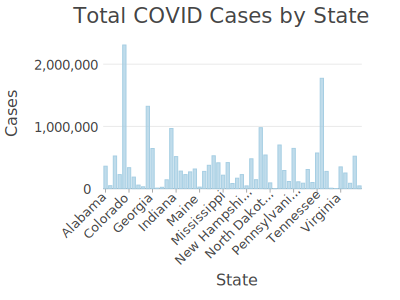

In [4]:
c = arcpy.Chart('bar_covid_by_state')
c.type = 'bar'
c.title = "Total COVID Cases by State"
c.xAxis.field = 'state'
c.xAxis.title = "State"
c.yAxis.field = 'cases_new'
c.yAxis.title = "Cases"
c.bar.aggregation = 'sum'
c.dataSource = 'memory/covid_daily'
c

The chart above is a good first attempt, but it's very difficult to read due to the small size.  I'll make the chart larger by setting the chart object's `displaySize` property.  I'll also arrange the bars in a more logical way by sorting them to be in descending order from most cases to fewest cases.

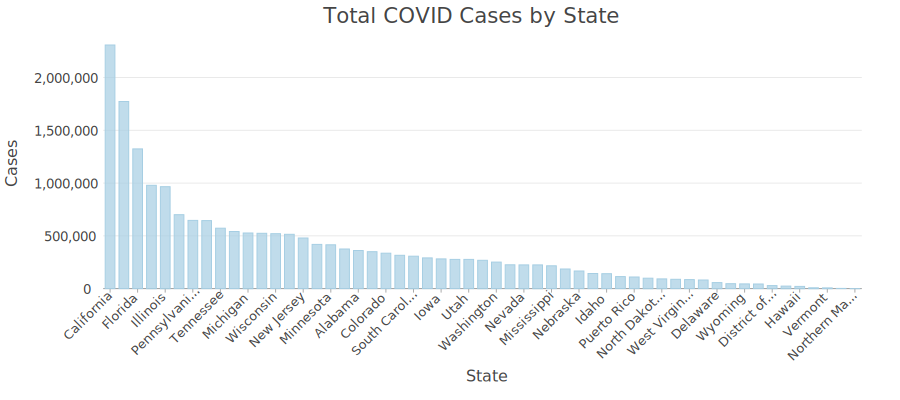

In [5]:
c = arcpy.Chart('bar_covid_by_state_desc')
c.type = 'bar'
c.title = "Total COVID Cases by State"
c.xAxis.field = 'state'
c.xAxis.title = "State"
c.yAxis.field = 'cases_new'
c.yAxis.title = "Cases"
c.yAxis.sort = 'DESC'
c.bar.aggregation = 'sum'
c.displaySize = 900, 400
c.dataSource = 'memory/covid_daily'
c

Now I'll take a look at new cases per day for the entire United States by creating a bar chart with a date field on the X axis and the total aggregated daily COVID cases on the Y axis.    

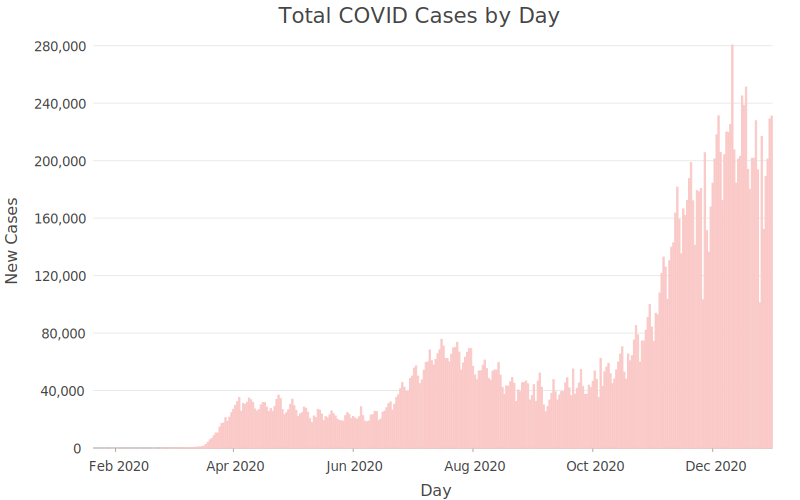

In [6]:
c = arcpy.Chart('bar_covid_daily')
c.type = 'bar'
c.title = "Total COVID Cases by Day"
c.xAxis.field = 'date'
c.xAxis.title = "Day"
c.yAxis.field = 'cases_new'
c.yAxis.title = "New Cases"
c.bar.aggregation = 'sum'
c.color = ['#fac9c7']
c.displaySize = 800, 500
c.dataSource = 'memory/covid_daily'
c

The above chart is helpful for understanding the trajectory of daily COVID cases in the US, but this chart is difficult to interpret due to the existence of noise in the dataset.  As time progresses, you can see that the bars form many peaks and valleys, and this cyclical pattern is most likely due to inconsistent reporting of COVID cases.  To combat this noise, I can re-create the same chart, but this time I'll include a moving average line.  Moving averages are useful for smoothing out noise in a temporal dataset and highlighting the general pattern of the data.  

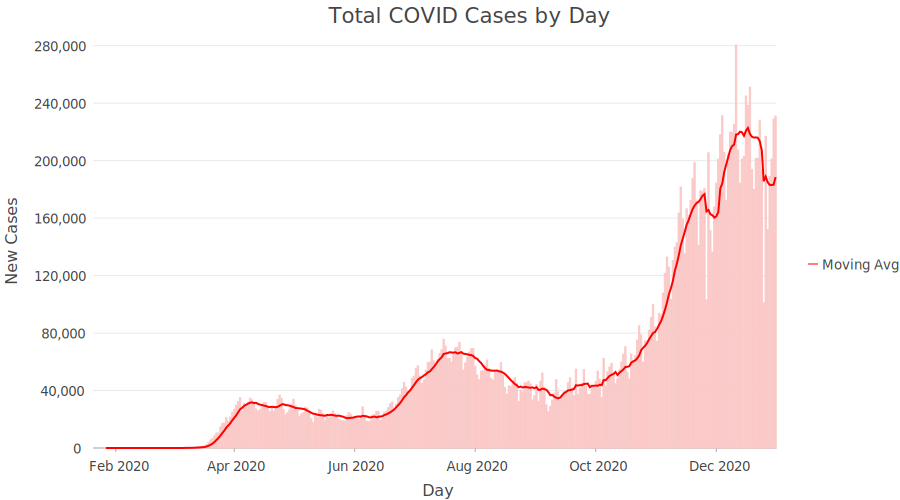

In [7]:
c = arcpy.Chart('bar_covid_daily_moving_avg')
c.type = 'bar'
c.title = "Total COVID Cases by Day"
c.xAxis.field = 'date'
c.xAxis.title = "Day"
c.yAxis.field = 'cases_new'
c.yAxis.title = "New Cases"
c.bar.aggregation = 'sum'
c.bar.showMovingAverage = True
c.color = ['#fac9c7']
c.displaySize = 900, 500
c.dataSource = 'memory/covid_daily'
c

I can also view aggregated COVID cases over time from a slightly different perspective by creating a <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/calendar-heat-chart.htm" target="_blank">calendar heat chart</a>.  This chart aggregates daily cases and displays them in a calendar grid.  The calendar heat chart is effective at showing a per day summary of temporal data, particularly when the values are unevenly distributed, as the color for each cell is determined by a graduated natural breaks scheme.

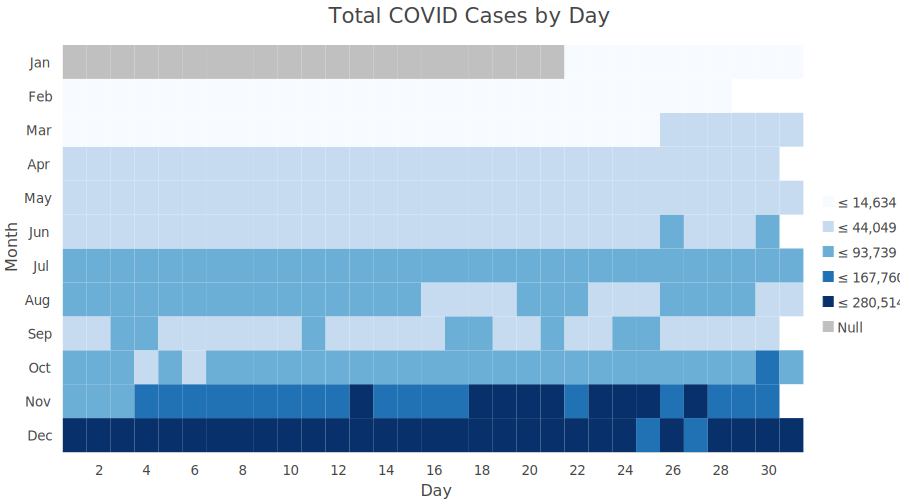

In [8]:
c = arcpy.Chart('chc_covid_daily')
c.type = 'calendarHeatChart'
c.title = "Total COVID Cases by Day"
c.xAxis.field = 'date'
c.xAxis.title = "Day"
c.yAxis.field = 'cases_new'
c.yAxis.title = "Month"
c.calendarHeatChart.aggregation = 'sum'
c.displaySize = 900, 500
c.dataSource = 'memory/covid_daily'
c

Having visualized the daily COVID cases aggregated for the entire country, I may also be interested in comparing daily cases between states.  To do this, I'll create a <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/line-chart.htm" target="_blank">line chart</a> and split the data by the `state` field.  This creates a separate line for each state.  

In [9]:
c = arcpy.Chart('line_covid_daily_by_state')
c.type = 'line'
c.title = "Total Cases by Day"
c.xAxis.field = 'date'
c.xAxis.title = "Day"
c.yAxis.field = 'cases_new'
c.yAxis.title = "New Cases"
c.yAxis.minimum = 0
c.line.aggregation = 'sum'
c.line.splitCategory = 'state'
c.line.timeIntervalSize = 1
c.line.timeIntervalUnits = 'DAYS'
c.displaySize = 900, 500
c.dataSource = 'memory/covid_daily'
c

Above, you can see that line charts become messy and difficult to interpret when many series are displayed (such charts are sometimes referred to pejoratively as <a href="https://www.data-to-viz.com/caveat/spaghetti.html" target="_blank">spaghetti plots</a>).  New in ArcGIS Pro 2.7, I can display this data in a clearer way by creating a <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/matrix-heat-chart.htm#GUID-44D462F3-5E67-46DD-BD1C-862003D2EA5C" target="_blank">matrix heat chart</a>. Matrix heat charts are used to visualize relationships between categorical or date fields with a grid of shaded cells.  Here I want to view each state on the Row axis and each day on the Column axis, and I'll use the `cases_new` field to determine the intensity of the cell shading.

In [10]:
c = arcpy.Chart('mhc_covid_by_state')
c.type = 'matrixHeatchart'
c.title = "Daily COVID Cases by State"
c.xAxis.field = 'date'
c.xAxis.title = 'Day'
c.yAxis.field = ['state', 'cases_new']
c.yAxis.title = 'State'
c.matrixHeatChart.aggregation = 'sum'
c.matrixHeatChart.classificationMethod = 'naturalBreaks'
c.matrixHeatChart.classCount = 7
c.matrixHeatChart.nullPolicy = 'zero'
c.legend.title = "Number of Cases"
c.displaySize = 800, 1200
c.dataSource = 'memory/covid_daily'
c

You can see that this chart allows for an easier comparison of daily COVID cases between states because each state is displayed as a separate row, whereas the line chart forces all states to compete for the same space.    

## Conclusion 

ArcPy Charts and ArcGIS Notebooks allow you to visually explore the patterns found in data with just a few simple lines of code. Dig into the <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/what-is-a-chart-.htm" target="_blank">Pro Charts</a> and <a href="https://pro.arcgis.com/en/pro-app/latest/arcpy/classes/chart.htm" target="_blank">ArcPy Chart</a> documentation to learn more about all the supported chart types and how you can configure them to suite your visualization needs. And keep in mind, <a href="https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/charts/make-a-chart.htm" target="_blank">making a chart</a> in the ArcGIS Pro UI is just as easy, and also provides interactivity between charts, maps, and tables.  I hope that you'll take advantage of ArcPy Charts and ArcGIS Notebooks in your next automation or spatial data science project!